In [1]:
import torch
import torch.nn as nn  
import torch.optim as optim  

import random

import gymnasium as gym

import imageio
from IPython.display import Image, display

import time
import math

Environment and neural network setup

You'll begin by setting up the environment you'll use throughout the course: the Lunar Lander environment, where an agent controls the thrusters for a vehicle attempting to land on the moon.

In [2]:
# Initiate the Lunar Lander environment
env = gym.make('LunarLander-v3', render_mode="rgb_array")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v3>>>>>

In [3]:
env.action_space

Discrete(4)

In [4]:
env.observation_space

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

In [5]:
# Define a neural network class that inherits from PyTorch's nn.Module base class
class Network(nn.Module):  
    
    def __init__(self, dim_inputs, dim_outputs):
        # Initialize the parent class (nn.Module) to properly set up the module
        super(Network, self).__init__()
        # Define a linear transformation (fully connected layer) with the specified input and output dimensions
        # This layer performs a linear mapping: y = xW^T + b, where W is the weight matrix and b is the bias vector
        self.linear = nn.Linear(dim_inputs, dim_outputs)

    def forward(self, x):
        # Define the forward pass of the network
        # When input `x` is passed to the network, it goes through the linear layer to produce the output
        return self.linear(x)

In [6]:
# Instantiate the network
network = Network(dim_inputs=8, dim_outputs=4)
network

Network(
  (linear): Linear(in_features=8, out_features=4, bias=True)
)

In [7]:
# Initialize the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [8]:
# dummy functions

def select_action(state, network):
    return random.randint(0, 3)

def calculate_loss(network, state, action, next_state, reward, done):
    return (network(torch.tensor(state))**2).mean()

In [9]:
# Run ten episodes
for episode in range(10):
    state, info = env.reset()
    done = True    
    # Run through steps until done
    while done:
        action = select_action(network, state)        
        # Take the action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated        
        loss = calculate_loss(network, state, action, next_state, reward, done)
        print('state:', state)
        print('loss:', loss)
        
        # Reset the gradients of all parameters in the optimizer to zero.
        # This ensures that gradients from previous iterations do not accumulate.
        optimizer.zero_grad()
        
        # Perform backpropagation to compute the gradients of the loss function 
        # with respect to the model's parameters.
        loss.backward()
        
        # Update the model's parameters using the computed gradients.
        # The optimizer adjusts the parameters to minimize the loss.
        optimizer.step()     
        
        # Update the state
        state = next_state
    print(f"Episode {episode} complete."+'\n')

state: [-0.0032671   1.4022896  -0.33093503 -0.3835778   0.00379252  0.07496163
  0.          0.        ]
loss: tensor(0.2569, grad_fn=<MeanBackward0>)
Episode 0 complete.

state: [-0.00273113  1.4065846  -0.27666378 -0.19268407  0.00317164  0.0626684
  0.          0.        ]
loss: tensor(0.2409, grad_fn=<MeanBackward0>)
Episode 1 complete.

state: [ 0.00442953  1.4177121   0.44864684  0.30186298 -0.00512593 -0.10162524
  0.          0.        ]
loss: tensor(0.2113, grad_fn=<MeanBackward0>)
Episode 2 complete.

state: [ 0.00666857  1.4059902   0.6754273  -0.21912244 -0.00772029 -0.1529943
  0.          0.        ]
loss: tensor(0.2665, grad_fn=<MeanBackward0>)
Episode 3 complete.

state: [ 0.00777349  1.4128132   0.78735536  0.08411471 -0.00900075 -0.1783477
  0.          0.        ]
loss: tensor(0.2365, grad_fn=<MeanBackward0>)
Episode 4 complete.

state: [-0.00698061  1.4164956  -0.70708454  0.24777429  0.00809563  0.16016509
  0.          0.        ]
loss: tensor(0.2151, grad_fn=<Me

The Q-Network architecture

You are almost ready to train your first Deep Reinforcement Learning agent! Before you can go ahead with your first complete training loop, you need a neural network architecture to drive the agent's decisions and its ability to learn.

You will modify the generic architecture you defined in an earlier exercise.

In [10]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        # Instantiate the first hidden layer
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        # Instantiate the output layer
        self.fc3 = nn.Linear(64, action_size)
    def forward(self, state):
        # Ensure the ReLU activation function is used
        x = torch.relu(self.fc1(torch.tensor(state)))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Instantiating the Q-Network

Now that you defined its architecture, you are ready to instantiate the actual network that your agent will be using, as well as its optimizer. The Lunar Lander environment has a state space of dimension 8, and an action space of dimension 4 (corresponding to 0: do nothing, 1: left thruster, 2: main engine, 3: right thruster).

In [11]:
state_size = 8
action_size = 4
# Instantiate the Q Network
q_network = QNetwork(state_size, action_size)
q_network

QNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [12]:
# Specify the optimizer learning rate
optimizer = optim.Adam(q_network.parameters(), lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

Barebone DQN action selection

The select_action() function lets the agent select the action with highest Q-value at every step.

The function takes as argument the Q-network and the current state, and returns the index of the action with highest Q-value.

The Q-network is instantiated as q_network, and a random state loaded with state = torch.rand(8) to give example data to work with.

In [13]:
state = torch.rand(8)
state

tensor([0.0290, 0.2709, 0.9189, 0.4683, 0.6724, 0.5701, 0.8268, 0.0758])

In [14]:
q_network(state)

C:\Users\Alienware\AppData\Local\Temp\ipykernel_19828\927279601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


tensor([ 0.2267, -0.0413, -0.0446, -0.2551], grad_fn=<ViewBackward0>)

In [15]:
def select_action(q_network, state):
    
    # Calculate the Q-values
    q_values = q_network(state)
    # print("Q-values:", [round(x, 2) for x in q_values.tolist()])
    
    # Obtain the action index with highest Q-value
    action = torch.argmax(q_values).item()
    # print(f"Action selected: {action}, with q-value {q_values[action]:.2f}")
    
    return action

In [16]:
select_action(q_network, state)

C:\Users\Alienware\AppData\Local\Temp\ipykernel_19828\927279601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


0

Barebone DQN loss function

The calculate_loss() returns the network loss for any given step of the episode.

In [17]:
reward = 1
gamma = .99
done = False

state = torch.rand(8)
next_state = torch.rand(8)
action = select_action(q_network, state)

state, next_state, action

C:\Users\Alienware\AppData\Local\Temp\ipykernel_19828\927279601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


(tensor([0.6504, 0.3840, 0.6421, 0.8519, 0.5353, 0.3429, 0.1016, 0.6091]),
 tensor([0.8003, 0.0226, 0.7836, 0.4443, 0.8324, 0.0319, 0.6724, 0.1387]),
 0)

In [18]:
def calculate_loss(q_network, state, action, next_state, reward, done):
    q_values = q_network(state)
    # print(f'Q-values: {q_values}')
    
    # Obtain the current state Q-value
    current_state_q_value = q_values[action]
    # print(f'Current state Q-value: {current_state_q_value:.2f}')
    
    # Obtain the next state Q-value
    next_state_q_value = q_network(next_state).max()    
    # print(f'Next state Q-value: {next_state_q_value:.2f}')
    
    # Calculate the target Q-value
    target_q_value = reward + gamma * next_state_q_value * (1-done)
    # print(f'Target Q-value: {target_q_value:.2f}')
    
    # Obtain the loss
    loss = nn.MSELoss()(current_state_q_value, target_q_value)
    # print(f'Loss: {loss:.2f}')
    return loss


In [19]:
calculate_loss(q_network, state, action, next_state, reward, done)

C:\Users\Alienware\AppData\Local\Temp\ipykernel_19828\927279601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


tensor(0.9877, grad_fn=<MseLossBackward0>)

Training the barebone DQN

It's time to train a Barebone DQN algorithm in the Lunar Lander environment. Keep in mind this is still a bare algorithm, so the performance won't be great, but you'll improve on it later.

In [20]:
def describe_episode(episode, reward, episode_reward, t):
    landed = reward == 100
    crashed = reward == -100
    print(
        f"| Episode {episode+1:4} | Duration: {t:4} steps | Return: {episode_reward:<7.2f} |",
        "Landed   |" if landed else "Crashed  |" if crashed else "Hovering |",
    )

In [21]:
for episode in range(10):
    state, info = env.reset()
    done = False
    step = 0
    episode_reward = 0
    while not done:
        step += 1     
        # Select the action
        action = select_action(q_network, state)
        next_state, reward, terminated, truncated, _ = (env.step(action))
        done = terminated or truncated
        # Calculate the loss
        loss = calculate_loss(q_network, state, action, next_state, reward, done)
        optimizer.zero_grad()
        # Perform a gradient descent step
        loss.backward()
        optimizer.step()
        state = next_state
        episode_reward += reward
    describe_episode(episode, reward, episode_reward, step)

| Episode    1 | Duration:   89 steps | Return: -103.55 | Crashed  |
| Episode    2 | Duration:   53 steps | Return: -116.85 | Crashed  |
| Episode    3 | Duration:   74 steps | Return: -137.33 | Crashed  |
| Episode    4 | Duration:   74 steps | Return: -128.50 | Crashed  |
| Episode    5 | Duration:   88 steps | Return: -132.36 | Crashed  |
| Episode    6 | Duration:   86 steps | Return: -116.22 | Crashed  |
| Episode    7 | Duration:  110 steps | Return: -5.84   | Crashed  |
| Episode    8 | Duration:   54 steps | Return: -504.03 | Crashed  |
| Episode    9 | Duration:   55 steps | Return: -194.57 | Crashed  |
| Episode   10 | Duration:   52 steps | Return: -366.61 | Crashed  |


In [22]:
# After training the neural network
state, info = env.reset()
done = False
episode_reward = 0
frames = []
steps = 0

while not done:
    frame = env.render()  # Render the environment
    frames.append(frame)

    # Use the trained network to select the action
    action = select_action(q_network, state)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    state = next_state
    episode_reward += reward
    steps+=1

env.close()  # Close the rendering window

print('Steps:', steps)
print('Rewards:', episode_reward)

describe_episode(0, reward, episode_reward, steps)

Steps: 67
Rewards: -354.7270942096125
| Episode    1 | Duration:   67 steps | Return: -354.73 | Crashed  |


In [23]:
fps = 10
gif_path = "lunar_lander.gif"

# Save frames as a GIF
imageio.mimsave(gif_path, frames, fps=fps)

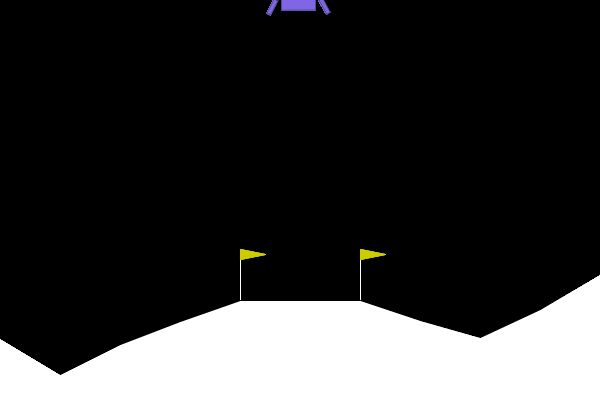

The episode has completed!


In [24]:
# Calculate the total duration of the GIF in seconds
gif_duration = math.ceil(steps / fps)

# Display the GIF
display(Image(filename=gif_path))

# Wait until the GIF finishes
time.sleep(gif_duration)

# Print a message after the GIF finishes
print("The episode has completed!")